## 1 赛题介绍



《绝地求生》(PUBG) 是一款战术竞技型射击类沙盒游戏。在该游戏中，玩家需要在游戏地图上收集各种资源，并在不断缩小的安全区域内对抗其他玩家，让自己生存到最后。当选手在本局游戏中取得第一名后，会有一段台词出现：“大吉大利，晚上吃鸡!”。

在本次赛题中，我们收集了PUBG比赛数据中玩家的行为数据，希望选手能够构建模型对玩家每局最终的排名进行预测。

![](https://ai-studio-static-online.cdn.bcebos.com/1b5af0d745464bb58e12c21f581b58374d296539da9d4538814351e2a569fca9)


## 2 赛事任务
构建吃鸡排名预测模型，输入每位玩家的统计信息、队友统计信息、本局其他玩家的统计信息，预测最终的游戏排名。这里的排名是按照队伍排名，若多位玩家在PUBG一局游戏中组队，则最终排名相同。

赛题训练集案例如下：
训练集5万局数据，共150w行
测试集共5000局条数据，共50w行

赛题数据文件总大小150MB，数据均为csv格式，列使用逗号分割。若使用Pandas读取数据，可参考如下代码：

```
import pandas as pd
import numpy as np

pubg_train = pd.read_csv('pubg_train.csv.zip')
```

测试集中label字段team_placement为空，需要选手预测。完整的数据字段含义如下：
- `match_id`：本局游戏的id
- `team_id`：本局游戏中队伍id，表示在每局游戏中队伍信息
- `game_size`：本局队伍数量
- `party_size`：本局游戏中队伍人数
- `player_assists`：玩家助攻数
- `player_dbno`：玩家击倒数
- `player_dist_ride`：玩家车辆行驶距离
- `player_dist_walk`：玩家不幸距离
- `player_dmg`：输出伤害值
- `player_kills`：玩家击杀数
- `player_name`：玩家名称，在训练集和测试集中全局唯一
- `kill_distance_x_min`：击杀另一位选手时最小的x坐标间隔
- `kill_distance_x_max`：击杀另一位选手时最大的x坐标间隔
- `kill_distance_y_min`：击杀另一位选手时最小的y坐标间隔
- `kill_distance_y_max`：击杀另一位选手时最大的x坐标间隔
- `team_placement`：队伍排名

选手需要提交测试集队伍排名预测，具体的提交格式如下：
```
team_placement
19
19
37
37
49
49
13
13
```

## 3 评估指标

本次竞赛的使用绝对回归误差MAE进行评分，数值越低精度越高，评估代码参考：
```
from sklearn.metrics import mean_absolute_error
y_pred = [0, 2, 1, 3]
y_true = [0, 1, 2, 3]
100 - mean_absolute_error(y_true, y_pred)
```

## 4 数据分析

结合已有的赛题信息，接下来我们将深入分析数据内部的规律，找出**什么类型的队伍会取得更好的排名？**
- 赛题字段分析
- 赛题标签分析
- 字段相关性分析


## Baseline使用指导
1、点击‘fork按钮’，出现‘fork项目’弹窗         
2、点击‘创建按钮’ ，出现‘运行项目’弹窗    
3、点击‘运行项目’，自动跳转至新页面      
4、点击‘启动环境’ ，出现‘选择运行环境’弹窗     
5、选择运行环境（启动项目需要时间，请耐心等待），出现‘环境启动成功’弹窗，点击确定        
6、点击进入环境，即可进入notebook环境      
7、鼠标移至下方每个代码块内（代码块左侧边框会变成浅蓝色），再依次点击每个代码块左上角的‘三角形运行按钮’，待一个模块运行完以后再运行下一个模块，直至全部运行完成   
![](https://ai-studio-static-online.cdn.bcebos.com/226c72f88f5b4e9d8a55e59129e4c79770aa200f10ef413ca1420ae7d273bc88)  
![](https://ai-studio-static-online.cdn.bcebos.com/866a22a341d64166aaf9a8a3abee09b5a6e2d0cba1c649bb8bdef6b2ad7955f1)  
8、下载页面左侧submission.zip压缩包  
![](https://ai-studio-static-online.cdn.bcebos.com/b7f3076301e34462abaf2013dcdbf10a5dcbfe287d5845f1869493e578391f7a)  
9、在比赛页提交submission.zip压缩包，等待系统评测结束后，即可登榜！    
![](https://ai-studio-static-online.cdn.bcebos.com/95a9fc4140144a2d8a76258f7a536751c5c6969994154d3da71c80e23757c6c8)  
10、点击页面左侧‘版本-生成新版本’  
![](https://ai-studio-static-online.cdn.bcebos.com/e62d0f5ca1454f7485c3eb1351823315480356cafad143c2ab2ff065f95104fe)  
11、填写‘版本名称’，点击‘生成版本按钮’，即可在个人主页查看到该项目（可选择公开此项目哦）  

In [38]:
import pandas as pd
import paddle
import numpy as np

%pylab inline
import seaborn as sns

train_df = pd.read_csv('data/data137263/pubg_train.csv.zip')
test_df = pd.read_csv('data/data137263/pubg_test.csv.zip')

Populating the interactive namespace from numpy and matplotlib


In [39]:
train_df.shape, test_df.shape

((1500000, 16), (500000, 15))

In [40]:
train_df["team_placement"].head()

0     5
1     5
2    49
3    49
4    34
Name: team_placement, dtype: int64

In [ ]:
sns.heatmap(train_df.corr())

## 5 模型训练与验证

### 数据处理

In [41]:
train_df = train_df.drop(['match_id', 'team_id'], axis=1)
test_df = test_df.drop(['match_id', 'team_id'], axis=1)

train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [42]:
train_df["kill_distance_min"] = sqrt(train_df["kill_distance_x_min"]**2 + train_df["kill_distance_y_min"]**2)
train_df["kill_distance_max"] = sqrt(train_df["kill_distance_x_max"]**2 + train_df["kill_distance_y_max"]**2)
train_df["kill_distance_minmax"] = train_df["kill_distance_max"] - train_df["kill_distance_min"]
train_df["player_dist_all"] = train_df["player_dist_ride"] + train_df["player_dist_walk"]

train_df = train_df.reindex(columns=["game_size", "party_size", "player_assists", "player_dbno", "player_dist_ride", "player_dist_walk", "player_dmg", "player_kills", "player_name", \
    "kill_distance_min", "kill_distance_max", "kill_distance_minmax", "player_dist_all", "team_placement"])

test_df["kill_distance_min"] = sqrt(test_df["kill_distance_x_min"]**2 + test_df["kill_distance_y_min"]**2)
test_df["kill_distance_max"] = sqrt(test_df["kill_distance_x_max"]**2 + test_df["kill_distance_y_max"]**2)
test_df["kill_distance_minmax"] = test_df["kill_distance_max"] - test_df["kill_distance_min"]
test_df["player_dist_all"] = test_df["player_dist_ride"] + test_df["player_dist_walk"]

test_df = test_df.reindex(columns=["game_size", "party_size", "player_assists", "player_dbno", "player_dist_ride", "player_dist_walk", "player_dmg", "player_kills", "player_name", \
    "kill_distance_min", "kill_distance_max", "kill_distance_minmax", "player_dist_all"])

# test_df = test_df[]

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


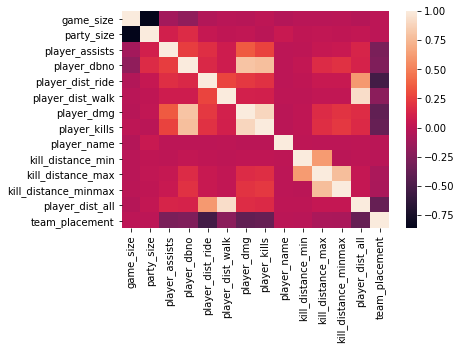

In [31]:
sns.heatmap(train_df.corr())

In [43]:
# 标签归一化，按照本场比赛的队伍数量进行处理
train_df['team_placement'] /= train_df['game_size'] 

# 数值归一化
for col in train_df.columns[:-1]:
    train_df[col] /= train_df[col].max()
    test_df[col] /= test_df[col].max()

In [44]:
train_df.shape, test_df.shape

((1500000, 14), (500000, 13))

### 模型搭建

In [ ]:
class Regressor(paddle.nn.Layer):
    # self代表类的实例自身
    def __init__(self):
        # 初始化父类中的一些参数
        super(Regressor, self).__init__()
        
        net_num = 100

        self.fc1 = paddle.nn.Linear(in_features=13, out_features=net_num)
        self.fc2 = paddle.nn.Linear(in_features=net_num, out_features=net_num)
        self.fc3 = paddle.nn.Linear(in_features=net_num, out_features=net_num)
        self.fc4 = paddle.nn.Linear(in_features=net_num, out_features=net_num)
        self.fc5 = paddle.nn.Linear(in_features=net_num, out_features=net_num)
        self.fc6 = paddle.nn.Linear(in_features=net_num, out_features=net_num)
        self.fc7 = paddle.nn.Linear(in_features=net_num, out_features=net_num)
        self.fc8 = paddle.nn.Linear(in_features=net_num, out_features=20)
        self.fc9 = paddle.nn.Linear(in_features=20, out_features=1)

        self.relu = paddle.nn.ReLU()
    
    # 网络的前向计算
    def forward(self, inputs):
        x = self.fc1(inputs)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.fc7(x)
        x = self.relu(x)
        x = self.fc8(x)
        x = self.relu(x)
        x = self.fc9(x)
        x = self.relu(x)
        return x

In [ ]:
# 声明定义好的线性回归模型
model = Regressor()

# 开启模型训练模式
model.train()

# 定义优化算法，使用随机梯度下降SGD
opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())

In [ ]:
opt = paddle.optimizer.SGD(learning_rate=0.0000001, parameters=model.parameters())

In [ ]:
# 加载模型参数
params_file_path="work/model/100net.pdparams"
model_state_dict = paddle.load(params_file_path)
model.load_dict(model_state_dict)

### 模型训练

In [24]:
EPOCH_NUM = 5000   # 设置外层循环次数
TRAIN_BATCH_SIZE = 1000  # 设置batch大小
BATCH_SIZE = 1000  # 设置batch大小
training_data = train_df.iloc[:-10000].values.astype(np.float32)
val_data = train_df.iloc[-10000:].values.astype(np.float32)

# 定义外层循环
for epoch_id in range(EPOCH_NUM):
    # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
    np.random.shuffle(training_data)
    
    # 将训练数据进行拆分，每个batch包含10条数据
    mini_batches = [training_data[k:k+TRAIN_BATCH_SIZE] for k in range(0, len(training_data), TRAIN_BATCH_SIZE)]
    
    train_loss = []
    for iter_id, mini_batch in enumerate(mini_batches):
        # 清空梯度变量，以备下一轮计算
        opt.clear_grad()

        x = np.array(mini_batch[:, :-1])
        y = np.array(mini_batch[:, -1:])
        
        # 将numpy数据转为飞桨动态图tensor的格式
        features = paddle.to_tensor(x)
        y = paddle.to_tensor(y)
        
        # 前向计算
        predicts = model(features)
        
        # 计算损失
        loss = paddle.nn.functional.l1_loss(predicts, label=y)
        avg_loss = paddle.mean(loss)
        train_loss.append(avg_loss.numpy())
        
        # 反向传播，计算每层参数的梯度值
        avg_loss.backward()

        # 更新参数，根据设置好的学习率迭代一步
        opt.step()
    
    mini_batches = [val_data[k:k+BATCH_SIZE] for k in range(0, len(val_data), BATCH_SIZE)]
    val_loss = []
    for iter_id, mini_batch in enumerate(mini_batches):
        x = np.array(mini_batch[:, :-1])
        y = np.array(mini_batch[:, -1:])
        
        features = paddle.to_tensor(x)
        y = paddle.to_tensor(y)
        
        predicts = model(features)
        loss = paddle.nn.functional.l1_loss(predicts, label=y)
        avg_loss = paddle.mean(loss)
        val_loss.append(avg_loss.numpy())

    print(f'Epoch {epoch_id}, train MAE {np.mean(train_loss)}, val MAE {np.mean(val_loss)}')

Epoch 0, train MAE 0.10623102635145187, val MAE 0.10608848184347153
Epoch 1, train MAE 0.10623100399971008, val MAE 0.10608824342489243
Epoch 2, train MAE 0.10623099654912949, val MAE 0.1060880795121193
Epoch 3, train MAE 0.10623099654912949, val MAE 0.10608796030282974
Epoch 4, train MAE 0.10623099654912949, val MAE 0.106087826192379
Epoch 5, train MAE 0.10623098164796829, val MAE 0.10608772933483124
Epoch 6, train MAE 0.10623098164796829, val MAE 0.10608766227960587
Epoch 7, train MAE 0.10623098164796829, val MAE 0.1060875877737999
Epoch 8, train MAE 0.1062309741973877, val MAE 0.1060875654220581
Epoch 9, train MAE 0.1062309741973877, val MAE 0.10608754307031631
Epoch 10, train MAE 0.1062309741973877, val MAE 0.10608754307031631
Epoch 11, train MAE 0.1062309741973877, val MAE 0.10608754307031631
Epoch 12, train MAE 0.1062309741973877, val MAE 0.10608750581741333
Epoch 13, train MAE 0.1062309741973877, val MAE 0.10608752071857452
Epoch 14, train MAE 0.1062309741973877, val MAE 0.10608

KeyboardInterrupt: 

### 模型预测

In [45]:
model.eval()
test_data = paddle.to_tensor(test_df.values.astype(np.float32))
test_predict = model(test_data)
test_predict = test_predict.numpy().flatten()
# test_predict = test_predict.round().astype(int)

In [46]:
train_df2 = pd.read_csv('data/data137263/pubg_train.csv.zip')
test_df2 = pd.read_csv('data/data137263/pubg_test.csv.zip')

train_df2 = train_df2.drop(['match_id', 'team_id'], axis=1)
test_df2 = test_df2.drop(['match_id', 'team_id'], axis=1)

train_df2 = train_df2.fillna(0)
test_df2 = test_df2.fillna(0)

test_df['team_placement'] = test_df2['game_size'] * test_predict

In [47]:
test_predict = test_df['team_placement'].round().astype(int)

In [48]:
test_predict

0         23
1         19
2         39
3         35
4         46
          ..
499995     5
499996    23
499997    21
499998    23
499999    23
Name: team_placement, Length: 500000, dtype: int64

In [49]:
pd.DataFrame({
    'team_placement': test_predict
}).to_csv('submission.csv', index=None)

!zip submission.zip submission.csv

  adding: submission.csv (deflated 68%)


In [50]:
model_name='100-2net'
# 保存模型参数
paddle.save(model.state_dict(), 'work/model/{}.pdparams'.format(model_name))
# 保存优化器信息和相关参数，方便继续训练
paddle.save(opt.state_dict(), 'work/model/{}.pdopt'.format(model_name))

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/framework/io.py:729: UserWarning: The input state dict is empty, no need to save.
  warnings.warn("The input state dict is empty, no need to save.")


## 6 总结与展望

项目使用全连接网络进行训练和预测。

后续改进方法有：
- 按照队伍进行聚合统计数据，构造新特征。
- 将标签归一化到0-1之间，进行训练。